### First attempt at integrating TF ML model with Spark with Mlflow model store.
#### WiP. Needs bug fixing on model save/load, likely due to incompatible vector format in spark/numpy/tf 

In [1]:
import findspark
SPARK_HOME = %env SPARK_HOME
findspark.init(SPARK_HOME)

In [2]:
#import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import os
from os import listdir
from functools import reduce
import sys

from pyspark.sql.dataframe import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType,StructField, StringType, IntegerType , BooleanType, DoubleType
from pyspark.sql.window import Window

from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.appName('yahoo').getOrCreate()
sc = spark.sparkContext

In [3]:
import mlflow
from mlflow import log_metric, log_param, log_artifact, pyfunc
from mlflow.pyfunc import PythonModel

"""
mlflow server \
    --backend-store-uri sqlite:///mlflow.db \
    --default-artifact-root ./artifacts \
    --host 0.0.0.0
"""

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("yahoo")

### File imports and EDA

In [66]:
mainpath = "yahoo_data/A2BENCHMARK/"
np.random.seed(111)
all_files = [f.name for f in os.scandir(mainpath) if f.is_file()]
test_files = np.random.choice(all_files, 30, replace=False)
[os.rename(mainpath + t, mainpath + "train/" + t) for t in  (set(all_files)-set(test_files))]
[os.rename(mainpath + t, mainpath + "test/" + t) for t in test_files]
len(test_files)

30

In [5]:
mainpath = "yahoo_data/A2BENCHMARK/"
df0 = spark.read.options(header='true', inferschema='true').csv(mainpath+"/train/synthetic_1.csv")
df0.printSchema()
df0.limit(3).toPandas()

root
 |-- timestamp: integer (nullable = true)
 |-- value: double (nullable = true)
 |-- is_anomaly: integer (nullable = true)



,timestamp,value,is_anomaly
0,1416726000,13.894031,0
1,1416729600,33.578274,0
2,1416733200,88.933746,0


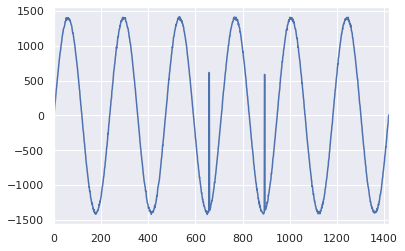

In [5]:
df0.toPandas().value.plot()

### Feature Engineering

In [6]:
train_dfs = [spark.read.options(header='true', inferschema='true').csv(mainpath + f"train/{csv}") for csv in os.listdir(mainpath + "train/")]
test_dfs = [spark.read.options(header='true', inferschema='true').csv(mainpath + f"test/{csv}") for csv in os.listdir(mainpath + "test/")]

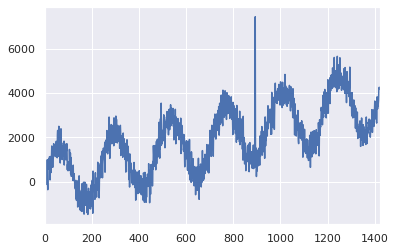

In [10]:
train_dfs[-1].toPandas().value.plot()

In [15]:
df0.limit(3).toPandas()

,timestamp,value,is_anomaly
0,1416726000,13.894031,0
1,1416729600,33.578274,0
2,1416733200,88.933746,0


In [63]:
def prepare_df(df: DataFrame) -> DataFrame:
    lag_amount = 5
    ts_window = Window.partitionBy().orderBy("timestamp")
    outdf = reduce(lambda df, i: df.withColumn(f"value_lag{i+1}", F.lag("value", i+1).over(ts_window)), list(range(lag_amount)), df)
    outdf = (outdf.withColumn("value_diff1", F.when(F.isnull(outdf.value - outdf.value_lag1), 0)
                                              .otherwise(outdf.value - outdf.value_lag1)))
    
    #2nd difference
    outdf = outdf.withColumn("value_diff1_lag1", F.lag(F.col("value_diff1")).over(ts_window))
    outdf = (outdf.withColumn("value_diff2", F.when(F.isnull(outdf.value_diff1 - outdf.value_diff1_lag1), 0)
                                              .otherwise(outdf.value_diff1 - outdf.value_diff1_lag1)))
    
    #outdf = outdf.na.fill(0)
    # Use backfill instead of na
    bf_window = Window.orderBy('timestamp').rowsBetween(0, sys.maxsize)
    outdf = reduce(lambda df_, col: df_.withColumn(col, F.first(df_[col], ignorenulls=True).over(bf_window)), outdf.columns, outdf)
                             
    quantiles = outdf.approxQuantile("value_diff1", [0.25,0.75],0.05)
    outdf = (outdf.join(outdf.agg(F.stddev(F.col("value_diff1")).alias("std")))
                  .withColumn("q1", F.lit(quantiles[0]))
                  .withColumn("q3", F.lit(quantiles[1])))
                
    quantiles = outdf.approxQuantile("value_diff2", [0.25,0.75],0.05)
    outdf = (outdf.join(outdf.agg(F.stddev(F.col("value_diff2")).alias("std2")))
              .withColumn("q1_2", F.lit(quantiles[0]))
              .withColumn("q3_2", F.lit(quantiles[1])))
    
    return outdf

In [62]:
prepare_df(df0).limit(3).toPandas()

,timestamp,value,is_anomaly,value_lag1,value_lag2,value_lag3,value_lag4,value_lag5,value_diff1,value_diff1_lag1,value_diff2,std,q1,q3,std2,q1_2,q3_2
0,1416726000,13.894031,0,13.894031,13.894031,13.894031,13.894031,13.894031,0.000000,0.000000,0.000000,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152
1,1416729600,33.578274,0,13.894031,13.894031,13.894031,13.894031,13.894031,19.684242,0.000000,19.684242,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152
2,1416733200,88.933746,0,33.578274,13.894031,13.894031,13.894031,13.894031,55.355473,19.684242,35.671230,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152


In [64]:
prepared_train_dfs = list(map(prepare_df, train_dfs))
prepared_test_dfs = list(map(prepare_df, test_dfs))
train_df = reduce(DataFrame.unionAll, prepared_train_dfs)
test_df = reduce(DataFrame.unionAll, prepared_test_dfs)

In [71]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
in_cols = ['value', *[f"value_lag{i+1}" for i in range(5)], "value_diff1", "value_diff2", "std", "std2", "q1", "q3", "q1_2", "q3_2"]
vecAssembler = VectorAssembler(inputCols=in_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled")
pipeline = Pipeline(stages=[vecAssembler, scaler])
X_train = pipeline.fit(train_df).transform(train_df)
X_train.limit(3).toPandas()

,timestamp,value,is_anomaly,value_lag1,value_lag2,value_lag3,value_lag4,value_lag5,value_diff1,value_diff1_lag1,value_diff2,std,q1,q3,std2,q1_2,q3_2,features,scaled
0,1416726000,13.894031,0,13.894031,13.894031,13.894031,13.894031,13.894031,0.000000,0.000000,0.000000,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,"[13.8940312022431, 13.8940312022431, 13.894031...","[0.01911914790719686, 0.01911914790719686, 0.0..."
1,1416729600,33.578274,0,13.894031,13.894031,13.894031,13.894031,13.894031,19.684242,0.000000,19.684242,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,"[33.5782735451433, 13.8940312022431, 13.894031...","[0.019288831071387253, 0.01911914790719686, 0...."
2,1416733200,88.933746,0,33.578274,13.894031,13.894031,13.894031,13.894031,55.355473,19.684242,35.671230,109.074353,-25.483616,20.314604,150.285365,-19.08794,15.371152,"[88.9337461757894, 33.5782735451433, 13.894031...","[0.01976600929280915, 0.019288831071387253, 0...."


In [88]:
X_train_vec = X_train.toPandas().scaled

In [96]:
Y_train_vec = np.array(X_train.toPandas().is_anomaly)

In [129]:
X_train_vec2 = np.asmatrix([np.array(row) for row in X_train_vec])

In [157]:
X_test = pipeline.fit(test_df).transform(test_df)
X_test_vec = np.asmatrix([np.array(row) for row in X_test.toPandas().scaled])
Y_test_vec = np.array(X_test.toPandas().is_anomaly)

In [166]:
import tensorflow as tf
from tensorflow.keras import layers

#import org.apache.spark.ml.feature.MinMaxScaler

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

input_dim = len(X_train.rdd.take(1)[0].features)
encoding_dim = 12 # first layer
hidden_dim = int(encoding_dim / 2) #hidden layer

nb_epoch = 2
batch_size = 16
learning_rate = 0.3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu")(input_layer) #, activity_regularizer=regularizers.l1(10e-5)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(1, activation='sigmoid')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.BinaryCrossentropy())

history = autoencoder.fit(X_train_vec2, Y_train_vec,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=False,
                    validation_data=(X_train_vec2, Y_train_vec),
                    verbose=1)
                    #callbacks=[checkpointer, tensorboard]).history

Train on 99470 samples, validate on 99470 samples
Epoch 1/2
99470/99470 [==============================] - 22s 226us/sample - loss: 0.0240 - val_loss: 0.0222
Epoch 2/2
99470/99470 [==============================] - 25s 256us/sample - loss: 0.0229 - val_loss: 0.0222


In [148]:
tf.saved_model.save(autoencoder, "./tf_models")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./tf_models/assets


In [154]:
mlflow.keras.log_model(autoencoder, registered_model_name="tf_model", artifact_path="tf_models")

Successfully registered model 'tf_model'.
Created version '1' of model 'tf_model'.


In [155]:
def apply_prediction_saved(df: DataFrame, model_path: str = "models:/tf_model/1", columns = ["scaled"]):
    prediction_udf = mlflow.pyfunc.spark_udf(spark, model_path)
    return df.withColumn('prediction', prediction_udf(*columns))

In [160]:
X_test.select("scaled", "is_anomaly")

DataFrame[scaled: vector, is_anomaly: int]

In [163]:
apply_prediction_saved(X_test.select("scaled", "is_anomaly")).show(5)

Py4JJavaError: An error occurred while calling o17859.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4941.0 failed 1 times, most recent failure: Lost task 0.0 in stage 4941.0 (TID 3915, 192.168.56.1, executor driver): java.lang.UnsupportedOperationException: Unsupported data type: struct<type:tinyint,size:int,indices:array<int>,values:array<double>>
	at org.apache.spark.sql.util.ArrowUtils$.toArrowType(ArrowUtils.scala:57)
	at org.apache.spark.sql.util.ArrowUtils$.toArrowField(ArrowUtils.scala:103)
	at org.apache.spark.sql.util.ArrowUtils$.$anonfun$toArrowSchema$1(ArrowUtils.scala:132)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at org.apache.spark.sql.types.StructType.foreach(StructType.scala:102)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at org.apache.spark.sql.types.StructType.map(StructType.scala:102)
	at org.apache.spark.sql.util.ArrowUtils$.toArrowSchema(ArrowUtils.scala:131)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.writeIteratorToStream(ArrowPythonRunner.scala:76)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:383)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1932)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:218)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2120)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2139)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:467)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:420)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3627)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2697)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3618)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:764)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3616)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2697)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2904)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:300)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:337)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.lang.UnsupportedOperationException: Unsupported data type: struct<type:tinyint,size:int,indices:array<int>,values:array<double>>
	at org.apache.spark.sql.util.ArrowUtils$.toArrowType(ArrowUtils.scala:57)
	at org.apache.spark.sql.util.ArrowUtils$.toArrowField(ArrowUtils.scala:103)
	at org.apache.spark.sql.util.ArrowUtils$.$anonfun$toArrowSchema$1(ArrowUtils.scala:132)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at org.apache.spark.sql.types.StructType.foreach(StructType.scala:102)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at org.apache.spark.sql.types.StructType.map(StructType.scala:102)
	at org.apache.spark.sql.util.ArrowUtils$.toArrowSchema(ArrowUtils.scala:131)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.writeIteratorToStream(ArrowPythonRunner.scala:76)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:383)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1932)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:218)


In [162]:
evaluator = BinaryClassificationEvaluator().setRawPredictionCol("prediction").setLabelCol("is_anomaly")
result = evaluator.evaluate(apply_prediction_saved(X_test.select("scaled", "is_anomaly")))

Py4JJavaError: An error occurred while calling o17798.evaluate.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 4728.0 failed 1 times, most recent failure: Lost task 3.0 in stage 4728.0 (TID 3700, 192.168.56.1, executor driver): java.lang.UnsupportedOperationException: Unsupported data type: struct<type:tinyint,size:int,indices:array<int>,values:array<double>>
	at org.apache.spark.sql.util.ArrowUtils$.toArrowType(ArrowUtils.scala:57)
	at org.apache.spark.sql.util.ArrowUtils$.toArrowField(ArrowUtils.scala:103)
	at org.apache.spark.sql.util.ArrowUtils$.$anonfun$toArrowSchema$1(ArrowUtils.scala:132)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at org.apache.spark.sql.types.StructType.foreach(StructType.scala:102)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at org.apache.spark.sql.types.StructType.map(StructType.scala:102)
	at org.apache.spark.sql.util.ArrowUtils$.toArrowSchema(ArrowUtils.scala:131)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.writeIteratorToStream(ArrowPythonRunner.scala:76)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:383)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1932)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:218)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2120)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2139)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2164)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:304)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:151)
	at org.apache.spark.rdd.OrderedRDDFunctions.$anonfun$sortByKey$1(OrderedRDDFunctions.scala:63)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.OrderedRDDFunctions.sortByKey(OrderedRDDFunctions.scala:62)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$4$lzycompute(BinaryClassificationMetrics.scala:174)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$4(BinaryClassificationMetrics.scala:163)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions$lzycompute(BinaryClassificationMetrics.scala:165)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions(BinaryClassificationMetrics.scala:165)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.createCurve(BinaryClassificationMetrics.scala:245)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.roc(BinaryClassificationMetrics.scala:103)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.areaUnderROC(BinaryClassificationMetrics.scala:114)
	at org.apache.spark.ml.evaluation.BinaryClassificationEvaluator.evaluate(BinaryClassificationEvaluator.scala:120)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.lang.UnsupportedOperationException: Unsupported data type: struct<type:tinyint,size:int,indices:array<int>,values:array<double>>
	at org.apache.spark.sql.util.ArrowUtils$.toArrowType(ArrowUtils.scala:57)
	at org.apache.spark.sql.util.ArrowUtils$.toArrowField(ArrowUtils.scala:103)
	at org.apache.spark.sql.util.ArrowUtils$.$anonfun$toArrowSchema$1(ArrowUtils.scala:132)
	at scala.collection.TraversableLike.$anonfun$map$1(TraversableLike.scala:238)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at org.apache.spark.sql.types.StructType.foreach(StructType.scala:102)
	at scala.collection.TraversableLike.map(TraversableLike.scala:238)
	at scala.collection.TraversableLike.map$(TraversableLike.scala:231)
	at org.apache.spark.sql.types.StructType.map(StructType.scala:102)
	at org.apache.spark.sql.util.ArrowUtils$.toArrowSchema(ArrowUtils.scala:131)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.writeIteratorToStream(ArrowPythonRunner.scala:76)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:383)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1932)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:218)


In [ ]:
print(result)

In [29]:
evaluator = BinaryClassificationEvaluator().setRawPredictionCol("prediction").setLabelCol("is_anomaly")
result = evaluator.evaluate(apply_prediction_saved, df_test)
print(result)
log_artifact("yahoo.ipynb", "jup_logs")
log_param("type", "quantile_comb_diff")
log_param("na_fill_type", "backfill")
log_param("threshold1", str(3.4))
log_param("threshold2", str(4.2))
log_metric("AreaUnderROC", result)

"""
Currently, loading the model after saving it ends the run. In order to associate the current model with its params, I'm logging it again.
The consequences of this are that useful model versions iterate by 2, and every other experiment run is empty
"""
mlflow.pyfunc.log_model(
            python_model=UDFWrapper(),
            registered_model_name="yahoo_model_quant_comb_diff",
            artifact_path="yahoo_models"
        )
mlflow.end_run()

0.8344286635764028


Registered model 'yahoo_model_quant_comb_diff' already exists. Creating a new version of this model...
Created version '15' of model 'yahoo_model_quant_comb_diff'.
